<br><br>
<center><font size="6">Paolo Trimarchi, 3095852</font> </center> <br><br>
<center><font size="3">16 May 2021</font> </center>


This dataset is composed of 1400 samples with 20 features each. The first column
is the sample id. The second column in the dataset represents the label. There
are 2 possible values for the labels. The remaining columns are numeric
features.

Your task is the following: you should compare the performance of the
k-NearestNeighbors algorithm (implemented by
sklearn.neighbors.KNeighborsClassifier) with that of Logistic Regression
(implemented by sklearn.linear_model.LogisticRegression). Try to optimize both
algorithms' parameters and determine which one is best for this dataset. At the
end of the analysis, you should have chosen an algorithm and its optimal set of
parameters: write this choice explicitly in the conclusions of your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).

# 1. DATA

In [ ]:
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler,MaxAbsScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score

from pandas.plotting import scatter_matrix
from pandas import DataFrame
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV




%matplotlib inline

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ML/mldata_0003095852')

In [ ]:
df= pd.read_csv("mldata_0003095852.csv")

In [ ]:
df.head()

,Unnamed: 0,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,0,1,0.595524,-1.852193,-2.537769,1.344636,1.946390,-1.061598,-0.245629,-0.265525,0.439115,0.484402,-1.515500,-1.503631,-0.462352,-0.176772,1.946390,0.681144,1.698898,-0.378226,0.665294,-0.706543
1,1,0,0.414170,3.274759,3.582406,0.796513,-1.611388,-0.087801,-1.519245,-0.447901,1.030765,-2.275793,1.121997,-0.881878,-1.340327,1.158944,-1.611388,0.325059,1.293144,-0.962637,-2.396815,-1.608863
2,2,0,-1.384893,-0.288620,0.180551,0.347454,-1.886910,0.633000,-0.211776,1.471077,-0.131668,0.677660,0.512788,1.158950,-1.390083,-0.275056,-1.886910,-0.885853,0.404435,1.790922,1.028336,-0.606878
3,3,0,0.331781,-0.097753,0.688058,-0.891571,-1.174251,0.456710,0.476965,0.871684,-1.483795,1.041206,0.433230,0.839421,0.616190,-0.546545,-1.174251,-0.305743,-2.070172,3.029408,0.753648,-0.134622
4,4,1,0.479363,-1.203176,0.626816,1.004616,-2.579191,-0.837515,-0.914812,-0.525595,-0.966302,1.794843,0.791814,0.838663,-0.960843,0.915768,-2.579191,0.693270,-1.204904,0.938248,1.229826,-3.861164


In [ ]:
df.drop(columns="Unnamed: 0",inplace=True)

Since unnamed 0 isn't useful, we remove it.

## 1.1 DATA VISUALIZATION

Text(0.5, 1.0, 'Correlation Heatmap')

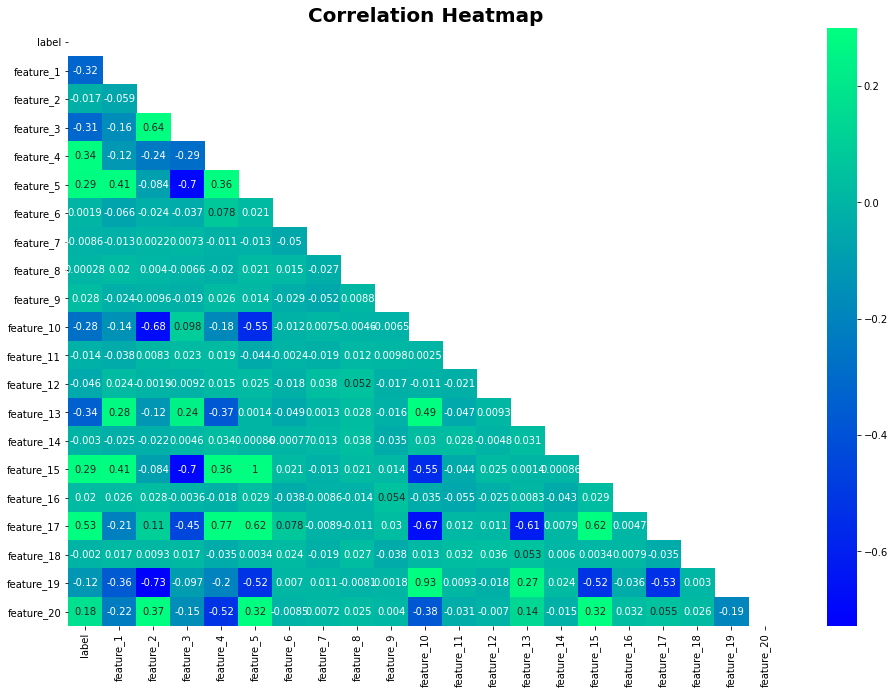

In [ ]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(16, 11))
ax = sns.heatmap(df.corr(), mask = mask, vmax=.3, annot=True, cmap="winter")
plt.title('Correlation Heatmap', fontsize=20,fontweight="bold")

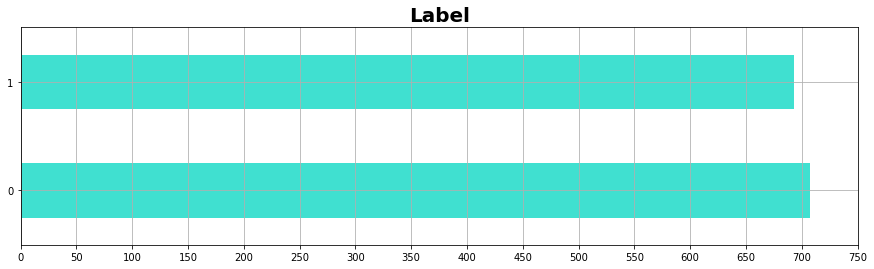

0    707
1    693
Name: label, dtype: int64


In [ ]:
c=df['label'].value_counts()
#se bilanciato usa accuracy per predizioni+ fai histogramma per valuecount
c.plot(kind='barh',color='Turquoise',grid=True, xticks=range(0,800,50),figsize=(15,4))

plt.title('Label', fontsize=20,fontweight="bold")


plt.show()

print(c)

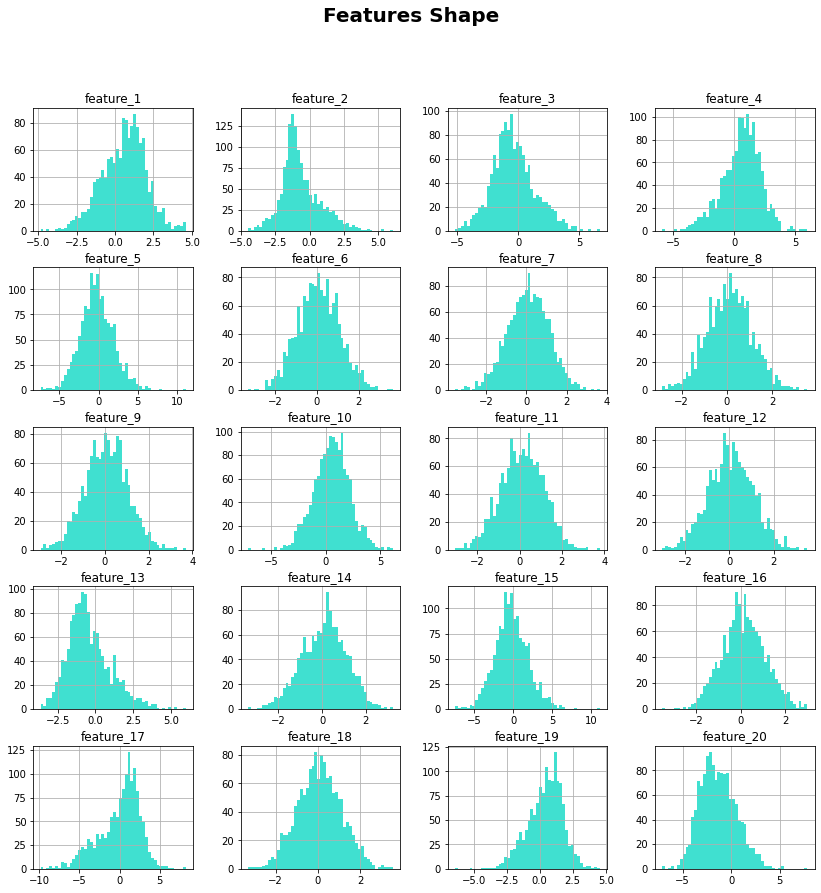

In [ ]:
df.drop(columns="label").hist(figsize=(14, 14),bins=50,color="Turquoise");
plt.suptitle('Features Shape', fontsize=20,fontweight="bold");


From what we can see the features are distributed similar to a normal

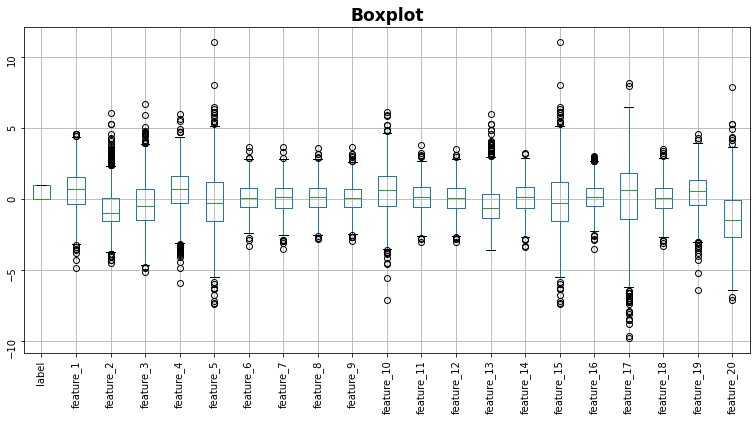

In [ ]:
df.boxplot(figsize=(13,6)).tick_params(labelrotation=90)
plt.title('Boxplot', fontsize=17,fontweight="bold");

In [ ]:
df.loc[df['feature_15']>10]


,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
999,0,3.588067,-1.815309,-5.152139,5.473931,11.098292,1.849058,0.815427,-0.331931,-0.047337,-2.497258,-1.204225,-0.031236,2.166088,0.545874,11.098292,1.071437,8.195007,1.821668,-2.821304,-0.216274


In [ ]:
df.loc[df['feature_5']>10]

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
999,0,3.588067,-1.815309,-5.152139,5.473931,11.098292,1.849058,0.815427,-0.331931,-0.047337,-2.497258,-1.204225,-0.031236,2.166088,0.545874,11.098292,1.071437,8.195007,1.821668,-2.821304,-0.216274


In [ ]:
df.drop(999, inplace=True)

As we have seen is it only a cell so dropping it would not make the Dataset lose significant information

In [ ]:
df.describe()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
count,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000,1399.000000
mean,0.495354,0.572389,-0.672805,-0.363417,0.583257,-0.189711,0.072540,0.081464,0.124413,0.065735,0.561122,0.116327,0.068929,-0.396362,0.097915,-0.189711,0.129339,0.009425,0.080399,0.428286,-1.331375
std,0.500157,1.425430,1.418475,1.729467,1.532405,2.110609,0.998872,1.022141,0.992823,0.976156,1.628327,1.007683,1.013743,1.442585,1.029413,2.110609,0.974768,2.575554,1.044210,1.323206,1.884318
min,0.000000,-4.850308,-4.501083,-4.840064,-5.915655,-7.395145,-3.305688,-3.542201,-2.851430,-2.943473,-7.142622,-3.042400,-3.029380,-3.638641,-3.396684,-7.395145,-3.532371,-9.819746,-3.317511,-6.414842,-7.104538
25%,0.000000,-0.381005,-1.522642,-1.483687,-0.290515,-1.554602,-0.591727,-0.619754,-0.555942,-0.594385,-0.462933,-0.557279,-0.625548,-1.369139,-0.622265,-1.554602,-0.494129,-1.443805,-0.617670,-0.411277,-2.693532
50%,0.000000,0.715443,-0.961742,-0.529802,0.718992,-0.258929,0.056931,0.111716,0.141818,0.089205,0.614371,0.134721,0.073200,-0.633204,0.168942,-0.258929,0.124050,0.617663,0.080563,0.587675,-1.459821
75%,1.000000,1.531719,0.029727,0.666758,1.589548,1.168802,0.774472,0.783309,0.798441,0.707180,1.626598,0.829079,0.755850,0.366812,0.822510,1.168802,0.773183,1.802162,0.780890,1.340524,-0.099274
max,1.000000,4.599007,6.054664,6.710736,6.007436,8.041808,3.632682,3.660634,3.563430,3.684965,6.161179,3.801416,3.523498,5.980039,3.232110,8.041808,2.996369,7.987946,3.546826,4.567432,7.863756


In [ ]:
df.corr()["label"].sort_values(ascending=False)

label         1.000000
feature_17    0.533671
feature_4     0.347864
feature_15    0.292472
feature_5     0.292472
feature_20    0.178071
feature_9     0.027737
feature_16    0.020293
feature_6     0.003197
feature_8    -0.000050
feature_18   -0.000851
feature_14   -0.002740
feature_7    -0.008052
feature_11   -0.014549
feature_2    -0.017930
feature_12   -0.045598
feature_19   -0.124912
feature_10   -0.279940
feature_3    -0.316707
feature_1    -0.319945
feature_13   -0.340089
Name: label, dtype: float64

From what we can see some features are highly correlated while some others are really low we can consider to perform PCA

# 2. BASIC MODELS

In [ ]:
X = df.drop(df.columns[0],axis=1)
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Now proceeding to do some preliminary tests, by using KNeighborsClassifier and LogisticRegression.

## 2.1 KNN

In [ ]:
neigh=KNeighborsClassifier()
neigh.fit(X_train,y_train)
first=neigh.predict(X_test)

In [ ]:
accuracy_first=accuracy_score(y_test,first)
mse_first= mean_squared_error(y_test,first)
f1=f1_score(y_test,first,average="binary")
roc=roc_auc_score(y_test,first)
print(roc)
print(f1)
print(accuracy_first)


0.888104038640332
0.8883610451306412
0.888095238095238



Since as we saw with data visualization the label are well balanced and also from this first results the three scores are really similar we will proceed by considering only the accuracy score

##2.2 LOGISTIC REGRESSION

In [ ]:
LR = LogisticRegression(random_state=0)
LR.fit(X_train, y_train)
second=LR.predict(X_test)

accuracy_second=accuracy_score(second,y_test)
print(accuracy_second)

0.7714285714285715


# 3 PCA

Since we saw that the correlation coefficient between features and labels are really high and other are really low we try to perform a PCA so to exclude some of the components without losing in overall accuracy.

In [ ]:
Scale = Normalizer()
LRpip=Pipeline([('PCA',PCA()),('scaler',Scale),('model',LogisticRegression())])


LRpip.fit(X_train,y_train)
second=LRpip.predict(X_test)


acc_LR=accuracy_score(second,y_test)
print(acc_LR)

0.7761904761904762


In [ ]:
Scale = Normalizer()
KNN_Pipeline=Pipeline([('PCA',PCA()),('scaler',Scale),('model',KNeighborsClassifier())])


KNN_Pipeline.fit(X_train,y_train)
second=KNN_Pipeline.predict(X_test)


accuracy_second=accuracy_score(second,y_test)
print(accuracy_second)

0.861904761904762


As we can see both models work better with a Normalizer rather than with all other scalers tried(MinMax,Standard and Robust). We saw that without the PCA the LR was actually performing better. These two models were performing really well at the beginning and  not improving much with the PCA and the Scaler usage we will later perform a GridSearch to better the accuracy.

# 4. EXTRA: RANDOM FOREST

Since I was not really able yet to ameliorate my models I decided to add another one to the project.

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
third=RF.predict(X_test)

accuracy_third=accuracy_score(third,y_test)

print(accuracy_third)


0.8976190476190476


In [ ]:
Scale = Normalizer()
RF_Pipeline=Pipeline([('PCA',PCA()),('scaler',Scale),('model',RandomForestClassifier())])


RF_Pipeline.fit(X_train,y_train)
second=RF_Pipeline.predict(X_test)


accuracy_second=accuracy_score(second,y_test)
print(accuracy_second)

0.888095238095238


# GRIDSEARCH


These are the final versions of the gridsearch and they are obtained after many trials in trying to improve the model, so that is why the research may look narrow at first sight.

In [ ]:

parameters = {'model__n_neighbors' : range(11,20,2), 'model__p': range(1,3),'model__weights':['uniform','distance'],'PCA__n_components':range(3,10),'model__algorithm':['auto'],'model__metric':['minkowski']}
n_components, svd_solver

clf = GridSearchCV(KNN_Pipeline, parameters, scoring='accuracy' ,cv=10)

clf.fit(X_train,y_train)

clf.best_params_

{'PCA__n_components': 5,
 'model__algorithm': 'auto',
 'model__metric': 'minkowski',
 'model__n_neighbors': 15,
 'model__p': 1,
 'model__weights': 'uniform'}

In [ ]:
KNN_Pipeline_Tuned=Pipeline([('PCA',PCA(n_components=5)),('scaler',Scale),('model',KNeighborsClassifier(n_neighbors=15,algorithm='auto',p=1,weights='uniform',metric='minkowski'))])

In [ ]:
KNN_Pipeline_Tuned.fit(X_train,y_train)
second=KNN_Pipeline_Tuned.predict(X_test)


accuracy_second=accuracy_score(second,y_test)
print(accuracy_second)

0.8952380952380953


In [ ]:
parameters = {'model__C':np.arange(0.2,1.4,0.2),'model__penalty': ['l2','elasticnet'],'model__solver':['newton-cg', 'liblinear'],'PCA__n_components':range(3,10),'PCA__svd_solver':['auto', 'full', 'arpack', 'randomized']}



clf = GridSearchCV(LR_Pipeline, parameters, scoring='accuracy' ,cv=10)

clf.fit(X_train,y_train)

clf.best_params_

{'model__C': 0.20000000000000004,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [ ]:
LR_Pipeline_Tuned=Pipeline([('PCA',PCA(n_components=10,svd_solve="full")),('scaler',Scale),('model',LogisticRegression(C=0.2,penalty='l2',solver='newton-cg'))])

In [ ]:
LR_Pipeline_Tuned.fit(X_train,y_train)
second=LR_Pipeline_Tuned.predict(X_test)


accuracy_second=accuracy_score(second,y_test)
print(accuracy_second)

0.7857142857142857


In [ ]:
parameters = {'model__n_estimators':range(300,350,10),'model__max_depth':range(8,11),'PCA__n_components':range(4,9)};


clf = GridSearchCV(RF_Pipeline, parameters, scoring='accuracy' ,cv=5)

clf.fit(X_train,y_train)

clf.best_params_

{'PCA__n_components': 6, 'model__max_depth': 10, 'model__n_estimators': 320}

In [ ]:
RF_Pipeline_Tuned=Pipeline([('PCA',PCA(n_components=6)),('scaler',Scale),('model', RandomForestClassifier(max_depth=10 ,n_estimators=320))])

In [ ]:
RF_Pipeline_Tuned.fit(X_train,y_train)
second=RF_Pipeline_Tuned.predict(X_test)


accuracy_second=accuracy_score(second,y_test)
print(accuracy_second)

0.9047619047619048


With the gridsearch all the three accuracies are improving a little bit.

# 6. VOTING CLASSIFIER

Lastly I wanted to try to give a final push in the performance by letting these three models cooperate in a unique ensemble model.

In [ ]:
estimators=[('rf',RF_Pipeline_Tuned),('knn',KNN_Pipeline_Tuned),('lr',LR_Pipeline_Tuned)]

VC=VotingClassifier(estimators)
VC.fit(X_train, y_train)
third=VC.predict(X_test)

accuracy_third=accuracy_score(third,y_test)

print(accuracy_third)

0.8952380952380953


In [ ]:
SC=StackingClassifier(estimators,cv=5)
SC.fit(X_train, y_train)
third=SC.predict(X_test)

accuracy_third=accuracy_score(third,y_test)

print(accuracy_third)

0.9023809523809524


Also by taking one of the estimators out the results of the ensembling doesn’t change.

# 7. CONCLUSION

I did not quite manage to improve the scores a lot, indeed all the final results that I got are not  far from what I got at the beginning. Once noticed this I decided to implement at the end a RandomForest, as it’s a strong algorithm with generally good performance and it revealed to be so even if it didn't improve much after tuning the parameters.
Overall I am really pleased with the results got at the end since they have great accuracy so I could not require them to be much higher otherwise I could have gotten into overfitting problems.